### Validation schema

In [5]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform


# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import catboost as cb

In [6]:
# # using ray engine for parallel calculation(for oprimization)
# %env MODIN_ENGINE=ray
# import modin.pandas as mpd

### Read data

In [7]:
# add data path to sys.path 
train_test_data_path = "C:\\Repository\\DS-Intership-data\\train_test_data\\"
sys.path.append(train_test_data_path)

# initiate dict for data
to_read_train_test_data = {}

# fill to_read
for dir_name, _, files in os.walk(train_test_data_path):
    for file in files:
        to_read_train_test_data[file] = dir_name + file

In [8]:
# check to_read
to_read_train_test_data

{'submission_example.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\submission_example.csv',
 'test_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\test_data.csv',
 'train_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\train_data.csv'}

In [9]:
%%time
data = {}
# read data
for file, path in to_read_train_test_data.items():
    data[file.split('.')[0]] = pd.read_csv(os.path.join(os.path.dirname(path), file), index_col=0)

CPU times: total: 20.4 s
Wall time: 23.4 s


### Validation schema

In [6]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=DecisionTreeRegressor(max_depth=1, random_state=42),
                 check_nans = True,
                 dropna = False,
                 check_infs = True, 
                 plot=True
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.plot = plot
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        if self.plot:
            split_history = {
                'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
                'Train Data': [], 
                'Validation Data': []
            }
            for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                split_history['Train Data'].append(train.max()-train.min())
                split_history['Validation Data'].append(val.max()-val.min())
            df = pd.DataFrame(split_history)
            print(df)
            sns.set(style="whitegrid")
            plt.figure(figsize=(6, 5))
            sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
            sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
            plt.title('Distribution of data for training and validation')
            plt.xlabel('Validation step')
            plt.ylabel('Data quantity')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        model = self.model
        
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def validate(self, predictions_by_ID = True, type="score"):
        
        score = np.array([])
        eval_report = {}
        
        # Evaluation loop
        step = 0
        for train, val in self.tscv.split(self.y):
            
            # Initialize steps and timer
            step += 1
            ts = time.time()

            # Split data step
            y_tr, y_val = self.y.iloc[train], self.y.iloc[val]
            X_tr, X_val = self.X.iloc[train], self.X.iloc[val]

            # Train step
            rng = np.random.RandomState(42)
            model = self.model
            model.fit(X_tr.values, y_tr.item_cnt_month.values)

            # Evaluation step
            y_tr_pr = pd.DataFrame(index=X_tr.index, data=model.predict(X_tr.values), columns=['item_cnt_month'])
            y_val_pr = pd.DataFrame(index=X_val.index, data=model.predict(X_val.values), columns=['item_cnt_month'])
            
            # Extract step (predictions by ID)
            if predictions_by_ID:
                nan_report = {}
                y_tr = y_tr.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train'] = f"{y_tr.item_cnt_month.isna().sum() / y_tr.shape[0] * 100} %"
                y_tr = y_tr.fillna(0)
                y_val = y_val.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val'] = f"{y_val.item_cnt_month.isna().sum() / y_val.shape[0] * 100} %"
                y_val = y_val.fillna(0)
                y_tr_pr = X_tr.join(y_tr_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train_pred'] = f"{y_tr_pr.item_cnt_month.isna().sum() / y_tr_pr.shape[0] * 100} %"
                y_tr_pr = y_tr_pr.fillna(0)
                y_val_pr = X_val.join(y_val_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val_pred'] = f"{y_val_pr.item_cnt_month.isna().sum() / y_val_pr.shape[0] * 100} %"
                y_val_pr = y_val_pr.fillna(0)
            
            # Calculate time required for step
            time_info = time.time() - ts
            
            # Metrics calucaltion step
            eval_report["step"+str(step)] = {
                "Train/Validation limits" : f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " +
                                      f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )",
                "Train/Validation error" : [self.calculate_metrics(y_tr_pr.item_cnt_month, y_tr.item_cnt_month),
                           self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month)],
                "Feature_importance" : model.feature_importances_,
                "Nan_report" : nan_report,
                "Time for step" : f"{time_info} s",
                "__________________" : "_________________________________________________________________________________"
            }
            np.append(score, self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month))
        
        # Return result of validation        
        if type == "report":    
            return eval_report
        elif type=="score":
            return score.mean()

### Advanced modeling

In [3]:
import optuna
import shap
shap.initjs()
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [7]:
class Pipeline:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 model=DecisionTreeRegressor(max_depth=1, random_state=42),
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 feature_importance_layer=True,
                 hyperparametr_optimization_layer=True,
                 params = None,
                 optimizer="Grid",
                 explainability_layer=True,
                 error_analysis_layer=True,
                 ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.model = model
        self.params = params
        self.optimizer = optimizer
        self.__feature_importance_layer__ = feature_importance_layer
        self.__hyperparametr_optimization_layer__=hyperparametr_optimization_layer
        self.__explainability_layer__=explainability_layer
        self.__error_analysis_layer__=error_analysis_layer

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"

        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
        
         # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        model = self.model
        model.fit(X_train, y_train)
        result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                       columns=['item_cnt_month']))\
                                            [['item_id', 'shop_id', 'item_cnt_month']].\
                            merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
        result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
        return result

    def validate(self, n_splits=5):
        
        validation = Validation(
                 self.train_data,
                 self.test_data,
                 self.submission_example,
                 n_splits=n_splits,
                 model = self.model,
                 check_nans=False,
                 plot=False
                )
            
        return validation.validate()
    
    
    def feature_importance_layer(self, selector="Boruta", sample_size=None):
        if sample_size is None:
            sample_size = self.train_data.shape[0]
        if selector=="Boruta":
            from boruta import BorutaPy
            # select sample of data
            X = self.train_data[self.train_data.date_block_num != 34].dropna().drop(columns='item_cnt_month')[:sample_size]
            y = self.train_data[self.train_data.date_block_num != 34].dropna()['item_cnt_month'][:sample_size]
            np.int = np.int_
            np.float = np.float_
            np.bool=np.bool_

            # init selector
            feat_selector = BorutaPy(RandomForestRegressor(max_depth=5, n_jobs=-1, n_estimators=20), 
                                     n_estimators=20, 
                                     verbose=0, 
                                     max_iter=20,
                                     random_state=42,
                                 )

            # fit selector
            feat_selector.fit(X.values, y.values)

            # extract usefull features
            mask = np.array(feat_selector.support_).reshape(4,8)
            plt.imshow(mask);
            plt.title("Feature selection")
            plt.show()
            important_features = data['train_data'].drop(columns=['item_cnt_month']).iloc[:, feat_selector.support_]

            # save info about usefull/useless features
            feature_importnce_report = {
                "important_columns": data['train_data'].drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, feat_selector.support_].columns,
                "unimportant_columns": data['train_data'].drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, ~feat_selector.support_].columns
            }
            print(feature_importance_report)
            
            return important_features
        
    def hyperparametr_optimization_layer(self, optimizer="Grid"):
        assert self.params is None, "Parameter are not initialized"
        
        if optimizer=="Optuna":
            
            # Optimization fucntion
            def objective(trial):
                params = {
                    "iterations": 100,
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                    "depth": trial.suggest_int("depth", 1, 10),
                    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
                    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                }

                model = Validation(
                                 self.train_data,
                                 self.test_data,
                                 self.submission_example,
                                 model = cb.CatBoostRegressor(**params),
                                 check_nans=False,
                                 plot=False
                                )
                rmse = model.validate()
                return rmse
            
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=30)
            
            print('Best hyperparameters:', study.best_params)
            print('Best RMSE:', study.best_value)
            
            return study.best_params
        
        if optimizer=="Hyperopt":
            
            # Optimization fucntion
            def objective(params):
            
                params['depth'] = int(params['depth'])

                # Model creation
                model = Validation(train_data=data['train_data'],
                           test_data=data['test_data'],
                           submission_example=data['submission_example'],
                           n_splits=5,
                           model = cb.CatBoostRegressor(iterations=5, **params, verbose=False),
                           check_nans=False,
                           plot=False
                          )

                # Calculate validation error
                return {'loss': model.validate(), 'status': STATUS_OK}

            # Define space for hyperparameters tuning
            space = {
                'depth': hp.quniform('depth', 2, 10, 1),
                'learning_rate': hp.loguniform('learning_rate', -3, 0),
                'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -2, 2)
            }

            # Trials for recording optimization process
            trials = Trials()

            # TPE optimizer
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

            # print best parameters
            print("Наилучшие параметры:")
            print(best)

            # Получаем наилучшую модель с наилучшими параметрами
            best_params = {**space_eval(space, best)}
            
            return best_params
            
        
    def explainability_layer(self):
        pass
    def error_analysis_layer(self):
        pass
    
    def evaluate(self):
        # optimal_hyperparametres = self.hyperparametr_optimization_layer()
        if self.__feature_importance_layer__:
            important_features = self.feature_importance_layer()
            
        if self.__feature_importance_layer__ and self.__hyperparametr_optimization_layer__:
            important_features = self.feature_importance_layer()
            optimal_hyperparametres = self.hyperparametr_optimization_layer(optimizer=self.optimizer)
            predictions = self.predict_target(optimal_hyperparametres, important_features)
        elif self.__feature_importance_layer__:
            important_features = self.feature_importance_layer()
            predictions = self.predict_target(important_features)
        elif self.__hyperparametr_optimization_layer__:
            optimal_hyperparametres = self.hyperparametr_optimization_layer(optimizer=self.optimizer)
            predictions = self.predict_target(optimal_hyperparametres)
        else:
            predictions = self.predict_target()
        # model_explanation = self.explainability_layer()
        # error_analysis = self.error_analysis_layer()
        return predictions

In [8]:
CatBoostTestOptuna = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(max_depth=2, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna"
                 #params = params
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically


In [15]:
CatBoostTestOptuna.evaluate()

In [8]:
%%time
CatBoostTestHyperopt = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(max_depth=2, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Hyperopt"
                 #params = params
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.03 s
Wall time: 3.15 s


In [11]:
CatBoostTestHyperopt.evaluate()

Shap Test

In [10]:
X = data['train_data'].drop(columns='item_cnt_month')
y = data['train_data']['item_cnt_month']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [24]:
model=cb.CatBoostRegressor(iterations=200)
model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 1.6562023	total: 235ms	remaining: 46.7s
1:	learn: 1.4039757	total: 481ms	remaining: 47.6s
2:	learn: 1.2917263	total: 748ms	remaining: 49.1s
3:	learn: 1.2463032	total: 996ms	remaining: 48.8s
4:	learn: 1.2238093	total: 1.25s	remaining: 48.8s
5:	learn: 1.2104088	total: 1.5s	remaining: 48.4s
6:	learn: 1.1962873	total: 1.78s	remaining: 49.2s
7:	learn: 1.1835603	total: 2.09s	remaining: 50.3s
8:	learn: 1.1770100	total: 2.34s	remaining: 49.6s
9:	learn: 1.1676062	total: 2.62s	remaining: 49.7s
10:	learn: 1.1634775	total: 2.92s	remaining: 50.1s
11:	learn: 1.1556986	total: 3.24s	remaining: 50.8s
12:	learn: 1.1482975	total: 3.5s	remaining: 50.4s
13:	learn: 1.1349601	total: 3.77s	remaining: 50s
14:	learn: 1.1303368	total: 4.02s	remaining: 49.5s
15:	learn: 1.1261131	total: 4.37s	remaining: 50.3s
16:	learn: 1.1217949	total: 4.66s	remaining: 50.2s
17:	learn: 1.1171435	total: 4.93s	remaining: 49.8s
18:	learn: 1.1129109	total: 5.26s	remaining: 50.1s
19:	learn: 1.1090862

161:	learn: 0.9397871	total: 51.1s	remaining: 12s
162:	learn: 0.9392530	total: 51.5s	remaining: 11.7s
163:	learn: 0.9385838	total: 51.8s	remaining: 11.4s
164:	learn: 0.9377775	total: 52.1s	remaining: 11.1s
165:	learn: 0.9364905	total: 52.4s	remaining: 10.7s
166:	learn: 0.9340019	total: 52.8s	remaining: 10.4s
167:	learn: 0.9338191	total: 53.1s	remaining: 10.1s
168:	learn: 0.9336417	total: 53.5s	remaining: 9.81s
169:	learn: 0.9330001	total: 53.8s	remaining: 9.49s
170:	learn: 0.9326894	total: 54.1s	remaining: 9.17s
171:	learn: 0.9324046	total: 54.4s	remaining: 8.85s
172:	learn: 0.9320222	total: 54.8s	remaining: 8.54s
173:	learn: 0.9316978	total: 55.1s	remaining: 8.23s
174:	learn: 0.9311284	total: 55.5s	remaining: 7.92s
175:	learn: 0.9307876	total: 55.9s	remaining: 7.62s
176:	learn: 0.9304305	total: 56.3s	remaining: 7.31s
177:	learn: 0.9301713	total: 56.6s	remaining: 7s
178:	learn: 0.9292069	total: 57.1s	remaining: 6.7s
179:	learn: 0.9288677	total: 57.5s	remaining: 6.38s
180:	learn: 0.9285

In [75]:
y_pred = pd.DataFrame(data=model.predict(X_train), columns=['item_cnt_month'])

In [121]:
%%time
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

CPU times: total: 1min 51s
Wall time: 1min 29s


In [146]:
shap_values = pd.DataFrame(shap_values.values).join(X_test[['item_id', 'shop_id']], on=X_test.index)

In [155]:
data['test_data'].shop_id.nunique()*data['test_data'].item_id.nunique()

198450

In [156]:
data['test_data'].shape

(198450, 32)

In [149]:
data['submission_example']

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [221]:
%%time
shap_values = explainer(data['test_data'])

CPU times: total: 6.33 s
Wall time: 4.36 s


In [222]:
type(shap_values[0])

shap._explanation.Explanation

In [230]:
data['test_data']

,date_block_num,shop_id,item_id,item_category_id,type_code,subtype_code,shop_city,shop_category,name2,name3,...,avg_by_month_shop_item_cnt_lag_2,avg_by_month_shop_item_cnt_lag_3,avg_by_month_city_item_cnt_lag_1,avg_by_month_cat_item_cnt_lag_1,delta_price_lag,category_cluster_id,item_price_cluster_id,cluster_id,item_shop_first_sale,item_first_sale
537,34,5,22154,37,8,1,3,7,5,554,...,0.22,0.25,0.20,0.25,-0.57,4,0,3,33,34
538,34,4,22154,37,8,1,2,8,5,554,...,0.14,0.19,0.15,0.25,-0.57,4,0,3,34,34
539,34,6,22154,37,8,1,4,1,5,554,...,0.33,0.31,0.27,0.25,-0.57,4,0,0,34,34
540,34,3,22154,37,8,1,1,6,5,554,...,0.14,0.13,0.11,0.25,-0.57,4,0,3,34,34
541,34,2,22154,37,8,1,0,8,5,554,...,0.16,0.18,0.13,0.25,-0.57,4,0,3,34,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11101193,34,46,8428,40,8,4,21,8,5,947,...,NaN,NaN,0.24,0.22,0.00,4,2,0,1,1
11101194,34,41,8428,40,8,4,18,8,5,947,...,NaN,NaN,0.14,0.22,0.00,4,2,3,1,1
11101195,34,44,8428,40,8,4,20,8,5,947,...,NaN,NaN,0.14,0.22,0.00,4,2,3,1,1
11101196,34,39,8428,40,8,4,18,6,5,947,...,NaN,NaN,0.14,0.22,0.00,4,2,1,1,1


In [244]:
[int(float_num) for float_num in shap_values[0].data[1:3]]

[5, 22154]

In [246]:
%%time
shap_info = {}

for i in range(len(shap_values)):
    shap_info[(int(float_num) for float_num in shap_values[i].data[1:3])] = shap_values[i]

CPU times: total: 2min 16s
Wall time: 2min 23s


In [247]:
shap_info

{<generator object <genexpr> at 0x00000199144F3840>: .values =
 array([-0.00480103,  0.0039852 ,  0.05644311, -0.00732001, -0.00038777,
         0.00082826, -0.00318535,  0.00014425, -0.00051721, -0.00391473,
        -0.07982585, -0.01907499, -0.02016184, -0.00409204,  0.01876442,
        -0.01322426, -0.01252969, -0.00219217, -0.06243691,  0.00699988,
         0.00241621, -0.00528197, -0.00112785,  0.00378631,  0.00351322,
        -0.00142126, -0.01162927,  0.        , -0.01298653, -0.0170238 ,
         0.0033615 , -0.02722078])
 
 .base_values =
 0.2719502768667129
 
 .data =
 array([ 3.40000000e+01,  5.00000000e+00,  2.21540000e+04,  3.70000000e+01,
         8.00000000e+00,  1.00000000e+00,  3.00000000e+00,  7.00000000e+00,
         5.00000000e+00,  5.54000000e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,             nan,  2.78967371e-01,  2.97523996e-01,
         3.06511424e-01,             nan,  1.13636364e-01,  9.30232558e-02,
         1.42857143e-01,  1.9503151

In [224]:
shap.plots.waterfall()

AttributeError: 'Explanation' object has no attribute 'iloc'

In [213]:
shap_values = pd.DataFrame(shap_values.values).join(data['test_data'][['item_id', 'shop_id']], on=data['test_data'].index)\
        .merge(data['submission_example'], on=['item_id', 'shop_id'], how='right')

In [102]:
y_pred.sort_values(by=['item_cnt_month'], ascending=False).iloc[random.randint(0, 2000)]

item_cnt_month   105.08
Name: 6472498, dtype: float64

In [50]:
import random

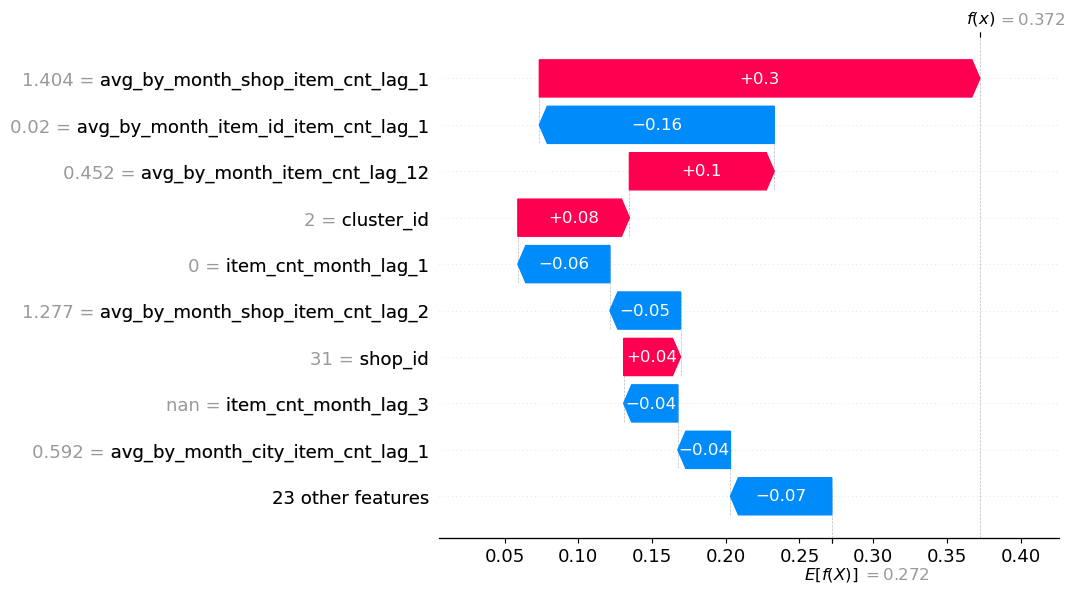

In [116]:
shap.plots.waterfall(shap_values[3])